# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.21 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import torch
import time

from collections import deque
from maddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def maddpg(n_episodes=6000, max_t=1000, print_every=1):
    
    max_scores = [] # list of max score from each episode
    moving_avgs = [] # list of moving averages per episode
    best_score = -np.inf
    scores_window = deque(maxlen=100) # mean score from last 100 episodes
    initial_time = time.time()
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations # fetch current state for each observation
        score = np.zeros(num_agents)
        agent.reset() 
        start_time = time.time()
        for t in range(max_t):
            action1 = agent.act(state[0], add_noise=True) # select an action for agent 1
            action2 = agent.act(state[1], add_noise=True) # select an action for agent 2
            action = np.concatenate((action1, action2), axis=0) # concat actions
            env_info = env.step(action)[brain_name] # send all actions to env
            next_states = env_info.vector_observations # fetch next state per agent
            reward = env_info.rewards # fetch reward per agent
            done = env_info.local_done # check if episode is complete
            agent.step(state, action, reward, next_states, done, t) # do learning step
            state = next_states
            score += reward
            if np.any(done):
                break
        
        max_scores.append(np.max(score)) # save max score for each episode
        scores_window.append(max_scores[-1]) # save max score to window
        moving_avgs.append(np.mean(scores_window)) # save moving average
        
        if i_episode % print_every == 0:
            duration = time.time() - start_time
            print("\rEpisode {} ({}s)\tMax score: {:.3f}\tMoving Avg: {:.3f}"\
                  .format(i_episode, round(duration), max_scores[-1], moving_avgs[-1]))
        if moving_avgs[-1] >= 0.5:
            print("\nEnvironment solved in {:d} episodes.\tAverage score: {:.3f}\tTotal time take for training: {}s"\
                 .format(i_episode, moving_avgs[-1], (time.time()-initial_time)))
            torch.save(agent.actor_local.state_dict(), 'action_weights_tennis.pth')
            torch.save(agent.critic_local.state_dict(), 'critics_weights_tennis.pth')
            break
            
    return max_scores, moving_avgs

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1)

In [9]:
from workspace_utils import active_session
 
with active_session():
    scores, mean_scores = maddpg()

Episode 1 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 2 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 3 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 4 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 5 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 6 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 7 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 8 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 9 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 10 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 11 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 12 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 13 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 14 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 15 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 16 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 17 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 18 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 19 (1s)	Max score: 0.000	Moving Avg: 0.000
Episode 20 (1s)	Max score: 0.000	Moving 

Episode 161 (1s)	Max score: 0.000	Moving Avg: 0.008
Episode 162 (3s)	Max score: 0.100	Moving Avg: 0.009
Episode 163 (1s)	Max score: 0.000	Moving Avg: 0.009
Episode 164 (1s)	Max score: 0.000	Moving Avg: 0.009
Episode 165 (2s)	Max score: 0.100	Moving Avg: 0.009
Episode 166 (2s)	Max score: 0.100	Moving Avg: 0.010
Episode 167 (1s)	Max score: 0.000	Moving Avg: 0.010
Episode 168 (1s)	Max score: 0.000	Moving Avg: 0.010
Episode 169 (2s)	Max score: 0.100	Moving Avg: 0.011
Episode 170 (2s)	Max score: 0.100	Moving Avg: 0.012
Episode 171 (4s)	Max score: 0.100	Moving Avg: 0.013
Episode 172 (3s)	Max score: 0.090	Moving Avg: 0.014
Episode 173 (2s)	Max score: 0.090	Moving Avg: 0.015
Episode 174 (1s)	Max score: 0.000	Moving Avg: 0.015
Episode 175 (5s)	Max score: 0.200	Moving Avg: 0.017
Episode 176 (3s)	Max score: 0.100	Moving Avg: 0.018
Episode 177 (5s)	Max score: 0.190	Moving Avg: 0.020
Episode 178 (3s)	Max score: 0.090	Moving Avg: 0.021
Episode 179 (1s)	Max score: 0.000	Moving Avg: 0.021
Episode 180 

Episode 319 (4s)	Max score: 0.100	Moving Avg: 0.224
Episode 320 (5s)	Max score: 0.200	Moving Avg: 0.225
Episode 321 (4s)	Max score: 0.100	Moving Avg: 0.225
Episode 322 (7s)	Max score: 0.200	Moving Avg: 0.226
Episode 323 (4s)	Max score: 0.100	Moving Avg: 0.225
Episode 324 (4s)	Max score: 0.100	Moving Avg: 0.226
Episode 325 (7s)	Max score: 0.200	Moving Avg: 0.227
Episode 326 (3s)	Max score: 0.100	Moving Avg: 0.227
Episode 327 (5s)	Max score: 0.200	Moving Avg: 0.228
Episode 328 (4s)	Max score: 0.200	Moving Avg: 0.229
Episode 329 (4s)	Max score: 0.100	Moving Avg: 0.229
Episode 330 (2s)	Max score: 0.100	Moving Avg: 0.229
Episode 331 (5s)	Max score: 0.200	Moving Avg: 0.230
Episode 332 (14s)	Max score: 0.400	Moving Avg: 0.233
Episode 333 (16s)	Max score: 0.500	Moving Avg: 0.236
Episode 334 (4s)	Max score: 0.100	Moving Avg: 0.237
Episode 335 (4s)	Max score: 0.100	Moving Avg: 0.235
Episode 336 (4s)	Max score: 0.100	Moving Avg: 0.234
Episode 337 (4s)	Max score: 0.100	Moving Avg: 0.233
Episode 33

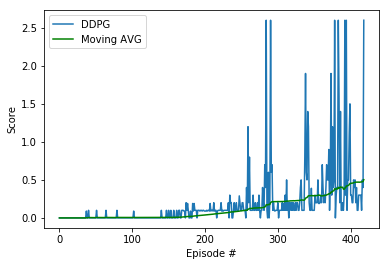

In [11]:
# plot scores across episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), mean_scores, c='g', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [12]:
env.close()